<a href="https://colab.research.google.com/github/diegoalejop/MIAD_NLP_2024/blob/main/Modelo_Final_NN_Competencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install livelossplot

In [18]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [17]:
# Importación librerías
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from keras import initializers
from keras import optimizers
from keras import activations
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Dropout, LSTM

from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping

from keras.preprocessing import sequence

from keras import optimizers, Input
from keras import backend as K
import keras.optimizers as opts

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import seaborn as sns

import nltk
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy

from scikeras.wrappers import KerasClassifier, KerasRegressor

import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'scikeras'

count    7895.000000
mean      748.820899
std       494.766799
min         3.000000
25%       412.000000
50%       655.000000
75%       951.500000
max      9408.000000
Name: len, dtype: float64
(254, 6)
(17, 6)
Descripción por conteo de balabras:
count    7895.000000
mean      144.770868
std        95.816408
min         1.000000
25%        80.000000
50%       127.000000
75%       183.000000
max      1863.000000
Name: word_count, dtype: float64


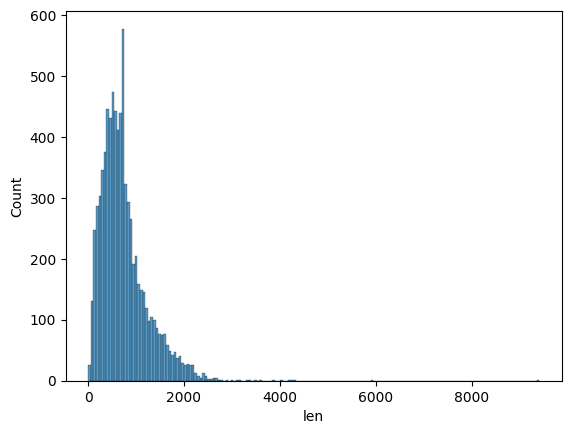

In [5]:
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTraining['len'] = dataTraining['plot'].str.len()
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)
sns.histplot(dataTraining['len'])
print(dataTraining['len'].describe())
print(dataTraining[dataTraining['len']>1900].shape)
print(dataTraining[dataTraining['len']<50].shape)

def count_words(text):
    words = text.split()
    return len(words)

# Aplicar la función a la columna 'description' y crear una nueva columna 'word_count'
print("Descripción por conteo de balabras:")
dataTraining['word_count'] = dataTraining['plot'].apply(count_words)
print(dataTraining['word_count'].describe())

In [6]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
#le = LabelEncoder()

y_genres = le.fit_transform(dataTraining['genres'])

In [7]:
#Importando diccionario de embeddings
#Se descarga de https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#Sugerido por tutorial de keras: https://keras.io/examples/nlp/pretrained_word_embeddings/
embedding_dim = 300 #Se define la dimensión de los embeddings usados. Se eleigen entre 50, 100, 200 y 300

path_to_glove_file = r'/content/glove.6B.'+str(embedding_dim)+'d.txt' #Ruta donde se descomprimen los txt
embeddings_index = {} #Se guarda el diccionario de los embeddings

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [8]:
#Funcion de procesamiento de texto
def procesaTexto(text,lematize =False, stemming = False):
    """
    Preprocesamiento de textos para utilizar en el modelo.

    Parametros:

    text(str): la cadena de texto a la que se le va a aplicar el procesamiento.
    lematize
    """
    text = text.lower() #Pasar el texto a minúsculas
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Eliminar palabras cortas
    text = re.sub(r'\d+', '', text)  # Eliminar números
    #Exclusión de stopwords
    english_stopwords = nltk.corpus.stopwords.words('english')
    words = text.split()
    words = [word for word in words if word.lower() not in english_stopwords]
    #Stemming
    if stemming == True:
        stemmer = PortStemmer()
        words = [stemmer.stem(word) for word in words]  # Aplicar stemming
    #Lematización
    if lematize ==True:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

#Función que obtiene los embedings de las palabras
def generaEmbedding(text):
    words = text.split()
    embeddings = []
    for word in words:
        if word in embeddings_index: #Se debe contar con el indice de embeddings
            embeddings.append(embeddings_index[word])
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)  # Si la palabra no existe se rellena del tamaño de la longitud de los embeddings
    return np.mean(embeddings, axis=0)


In [9]:
#Pre procesamiento del texto

#Para datos de entrenamiento
dataTraining['Plot Process'] = dataTraining['plot'].apply(procesaTexto) #Se alimpia limpieza de texto
X_embeddings = np.array([generaEmbedding(text) for text in dataTraining['Plot Process']]) #Se consiguen los embeddings
X_train_p, X_test_p, y_train_genres_p, y_test_genres_p = train_test_split(X_embeddings, y_genres, test_size=0.2, random_state=42) #Se separan los datos

#Para datos de prueba (competencia)
dataTesting['Plot Process'] = dataTesting['plot'].apply(procesaTexto) #Se alimpia limpieza de texto
X_embeddingsTest = np.array([generaEmbedding(text) for text in dataTesting['Plot Process']]) #Se consiguen los embeddings

# Pruebas

In [12]:
def nn_model_params(hp_optimizer ,
                    hp_neurons,
                    hp_activation,
                    hp_dropout,
                    hp_patience):

    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()

    # Definición de las capas de la red con el número de neuronas y la función de activación definidos en la función nn_model_params
    model.add(Dense(hp_neurons, input_shape=(X_train_p.shape[1],), activation=hp_activation))
    model.add(Dense(hp_neurons, activation=hp_activation))
    model.add(Dropout(hp_dropout))
    model.add(Dense(24))
    model.add(Activation(hp_activation))

    # Definición de función de perdida con parámetros definidos en la función nn_model_params
    model.compile(optimizer = hp_optimizer, loss='binary_crossentropy')

    # Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
    early_stopping = EarlyStopping(monitor="val_loss", patience = hp_patience)

    # Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
    model.fit(X_train, Y_train,
              validation_data = (X_val, Y_val),
              epochs=100,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True
              )

    return model

In [14]:
# Definición de parámetros y sus valores sobre los que se va a calibrar
nn_params = {
    'hp_optimizer': ['adam','sgd'],
    'hp_activation': ['relu','sigmoid'],
    'hp_neurons':[50,100,200,300],
    'hp_patience':[3,5],
    'hp_dropout': [0.4, 0.8]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn en la función nn_model_params
nn_model = KerasRegressor(build_fn=nn_model_params, verbose=0)

# Definición método GridSearch para la calibración de parámetros definidos en nn_params
rs = RandomizedSearchCV(nn_model, param_distributions=nn_params, n_iter=5, cv=3)
rs.fit(X_train, Y_train)

print('Los mejores parametros segun Randomnized Search:', rs.best_params_)

## Mejor modelo hasta el momento

- Datos lematizados y un vector de 100, dos capas sigmoides de 256, droput 0.55, llegando a un performance en prueba de ROC AUC de 0.8602 (Kaggle: 0.8672)
- Datos lematizados y un vector de 300, dos capas sigmoides de 256, droput 0.6, llegando a un performance en prueba de ROC AUC de 0.8842 (Kaggle: 0.8801)
- Datos sin lematizar y un vector de 300, 1 capa sigmoide de 256, 1 capa sigmoide de 200, dropout 0.55, llegando a un performance en prueba de ROC AUC de 0.8882 (Kaggle: 0.8814)
- Datos sin lematizar y un vector de 300, 1 capa sigmoide de 256, 1 capa sigmoide de 128, dropout 0.4, llegando a un performance en prueba de ROC AUC de 0.8905 (Kaggle: 0.8845)

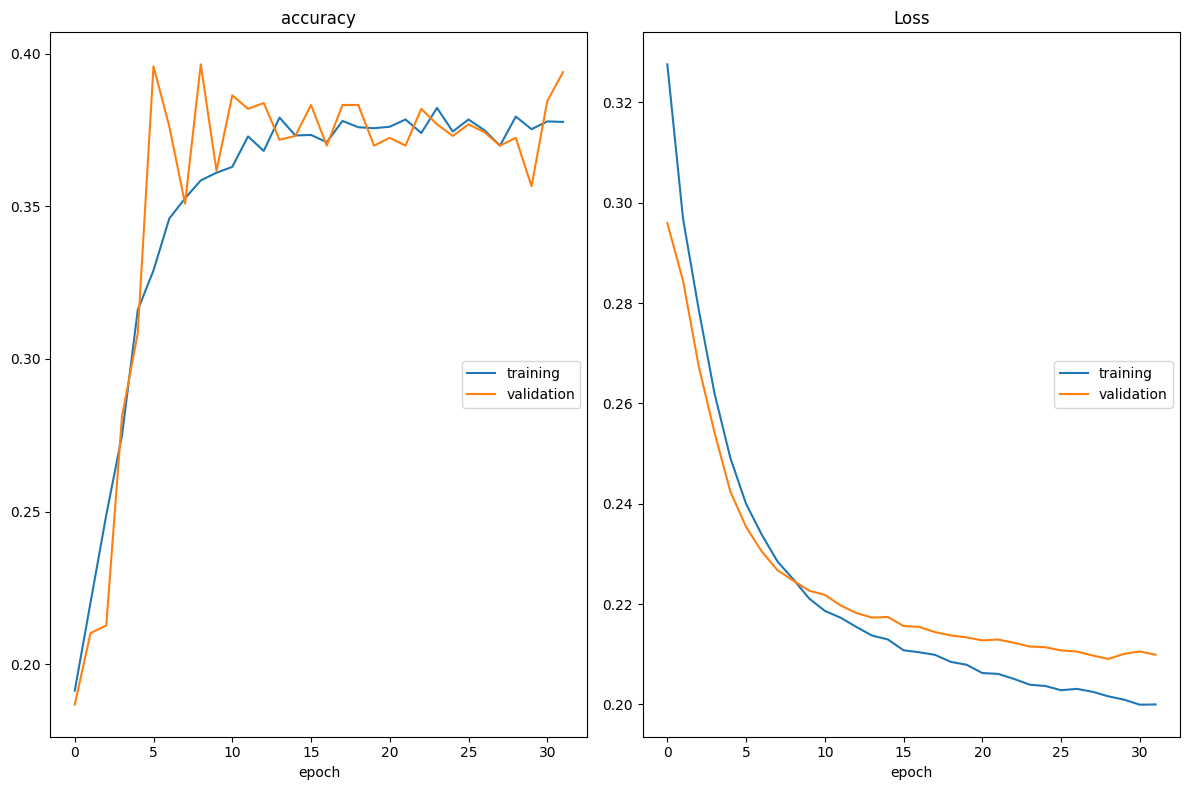

accuracy
	training         	 (min:    0.191, max:    0.382, cur:    0.378)
	validation       	 (min:    0.187, max:    0.396, cur:    0.394)
Loss
	training         	 (min:    0.200, max:    0.328, cur:    0.200)
	validation       	 (min:    0.209, max:    0.296, cur:    0.210)
50/50 [==============================] - 0s 3ms/step


0.8704494091888204

In [11]:
K.clear_session()
modelDep1 = Sequential()
modelDep1.add(Dense(256, input_shape=(X_train_p.shape[1],), activation='sigmoid'))
modelDep1.add(Dense(128, activation = 'sigmoid'))
modelDep1.add(Dropout(0.4))
modelDep1.add(Dense(24))
modelDep1.add(Activation('sigmoid'))
early_stopping = EarlyStopping(monitor="val_loss", patience = 3)
modelDep1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

modelDep1.fit(X_train_p, y_train_genres_p,
                    verbose=1,
                    epochs=100,
                    callbacks=[early_stopping, PlotLossesKeras()],
                    validation_data=(X_test_p, y_test_genres_p))

# Predicción del modelo de clasificación
y_pred_genres_p1 = modelDep1.predict(X_test_p)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres_p, y_pred_genres_p1, average='macro')

# Predicción

In [ ]:
#Guardar el mejor modelo
modelDep1.save('./Competencia/NN_genre.h5')
modelDep1.save('./Competencia/NN_genre.keras')

In [ ]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = modelDep1.predict(X_embeddingsTest)
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('.\Competencia\pred_genres_text_NN-Vect_Santiago4.csv', index_label='ID')
res.head()

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.002020,0.017231,0.001221,0.017631,0.444855,0.024910,0.000475,0.674402,0.029397,0.039253,...,0.039316,0.050448,0.000006,0.610990,0.001716,0.003583,0.000044,0.081761,0.002446,0.002098
4,0.074310,0.001152,0.000002,0.110262,0.119233,0.673642,0.012976,0.918467,0.000272,0.000017,...,0.000707,0.002079,0.000009,0.034206,0.000005,0.001047,0.004314,0.118782,0.002760,0.018822
5,0.068393,0.002376,0.000004,0.155829,0.063375,0.813856,0.021108,0.820229,0.000348,0.001653,...,0.000665,0.269750,0.000366,0.081714,0.001314,0.000656,0.000439,0.651030,0.001072,0.001252
6,0.234592,0.054370,0.000299,0.029771,0.062385,0.142712,0.006910,0.696231,0.002048,0.010763,...,0.000270,0.118655,0.000269,0.080885,0.125186,0.000686,0.000320,0.579496,0.049827,0.001251
7,0.006671,0.006299,0.001089,0.012421,0.128389,0.095257,0.005985,0.311629,0.007692,0.158141,...,0.003144,0.475309,0.000228,0.055452,0.072265,0.003311,0.000005,0.568882,0.000067,0.000142


# Test importación modelo prentrenado

In [ ]:
from tensorflow.keras.models import load_model
# Cargar el modelo guardado
loaded_model = load_model('./Competencia/NN_genre.h5')  # Usa el enfoque que prefieras
pred_prueba_disp =  loaded_model.predict(X_embeddingsTest)
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

rueba_imp = pd.DataFrame(pred_prueba_disp, index=dataTesting.index, columns=cols)
rueba_imp.head()